<a href="https://www.kaggle.com/code/nanski12/titanic-final-84-score?scriptVersionId=118998852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
pwd

'/kaggle/working'

In [3]:
#Load data

train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Analyze Data

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Separate test_df with passenger_id, will need for submission
test_id = test_df.pop("PassengerId")

test_id.head()

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [6]:
# Keep max index that will be used to back split training and test data
X_max_idx = train_df.shape[0]

print(X_max_idx)

891


In [7]:
# Separate the target variable
y = train_df.Survived

df = train_df.drop(['Survived', 'PassengerId'], axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


## Visualization

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Text(0.5, 1.0, 'Train set')

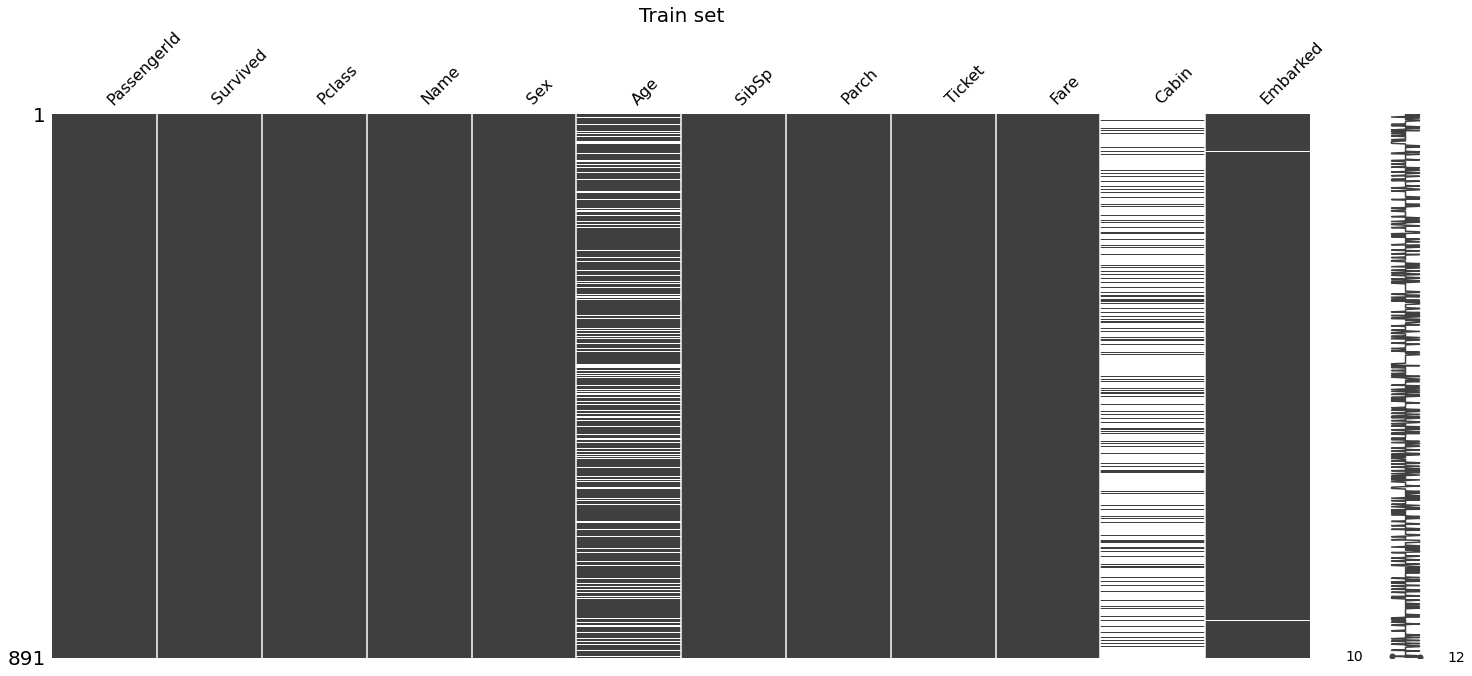

In [8]:
print(train_df.isnull().sum())
msno.matrix(train_df).set_title("Train set", fontsize=20) #Matrix to display data sparsity;exploratory visualization of missing data

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


Text(0.5, 1.0, 'Test set')

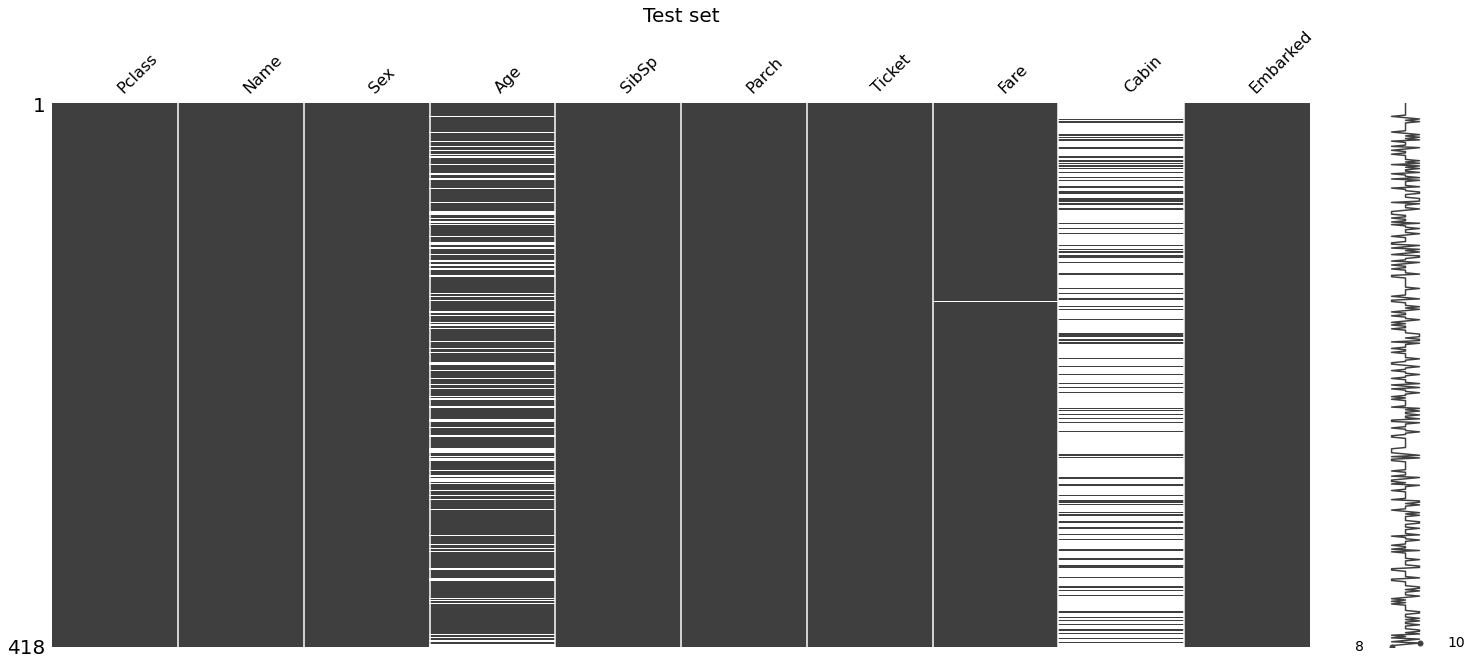

In [9]:
print(test_df.isnull().sum())
msno.matrix(test_df).set_title("Test set", fontsize=20)

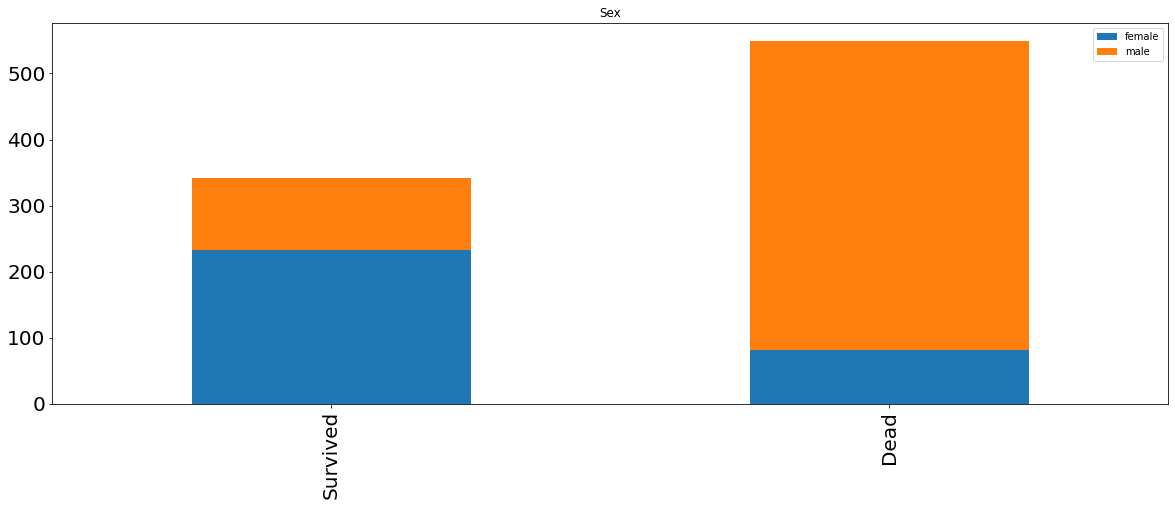

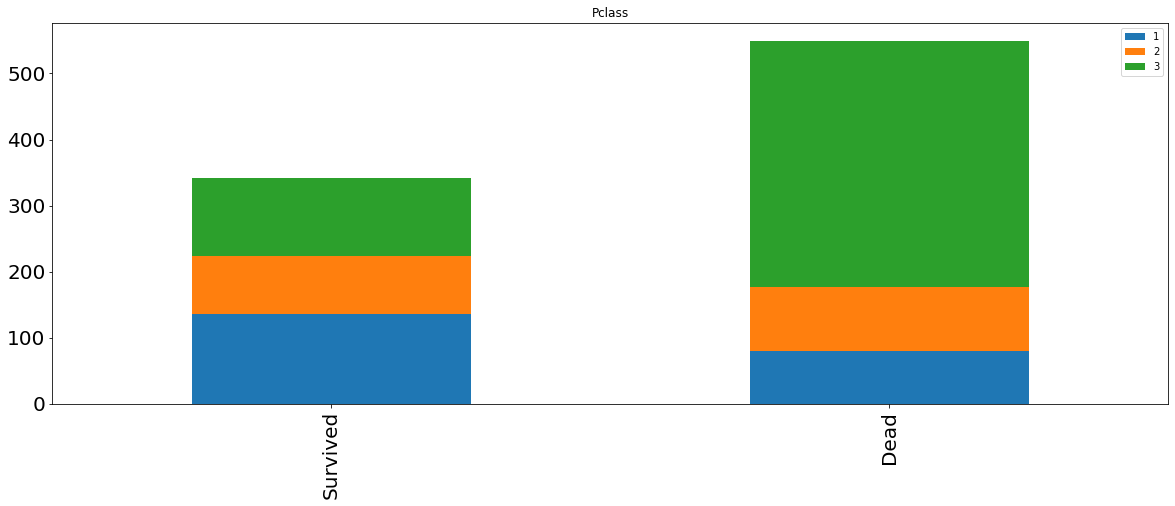

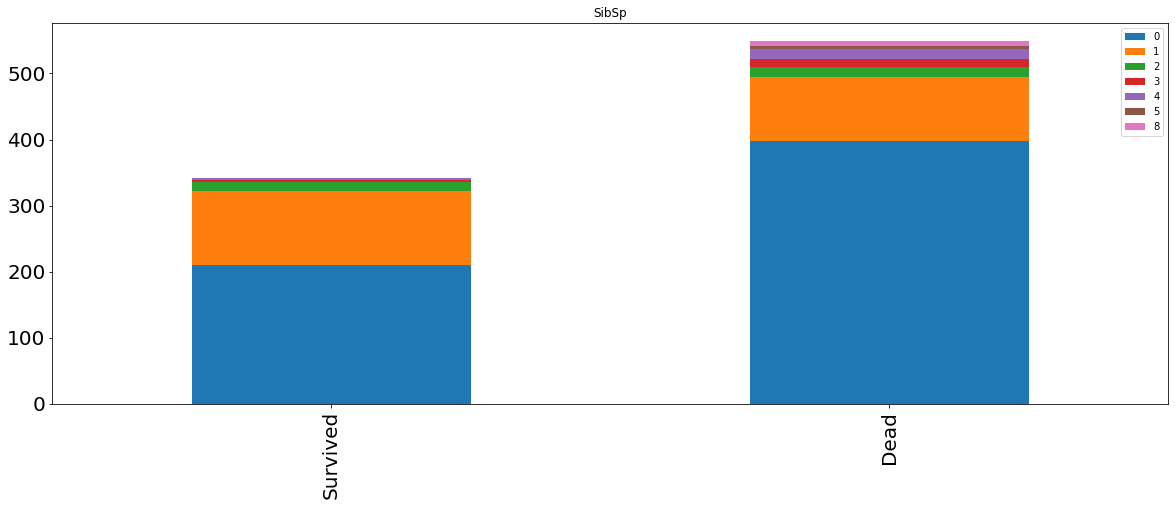

In [10]:
def bar_chart(feature):
    survived = train_df[train_df["Survived"]==1][feature].value_counts()
    dead = train_df[train_df["Survived"]==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ["Survived", "Dead"]
    df.plot(kind="bar", stacked = True, figsize=(20,7), title=feature, fontsize=20)
    
for a in ["Sex", "Pclass", "SibSp"]:
    bar_chart(a)

* Some features need imputations
* Cabin column has lot of missing values, so we will derive a new column using cabin and drop cabin
* We will derive a new column called deck_level, using correlation between pclass and information derived from cabin. Using this information, it would indicate the survivability of the people as the lifeboats were at top deck
* We will extract last name from name and use it as a new column
* We will extract title from name and use it as a new column

## Unprocessed data correlation

In [11]:
train_df.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

The above correlations show that the fare and Pclass columns have good impact on survivability. Higher the fare, higher the class and better chances of survivability. Pclass has 3 classes, 1,2,3 with 1 being the highest class (higher chance of survival) and 3 being the lowest class (lower chance of survival), as it is negatively correlated to Survived.

Feature instances

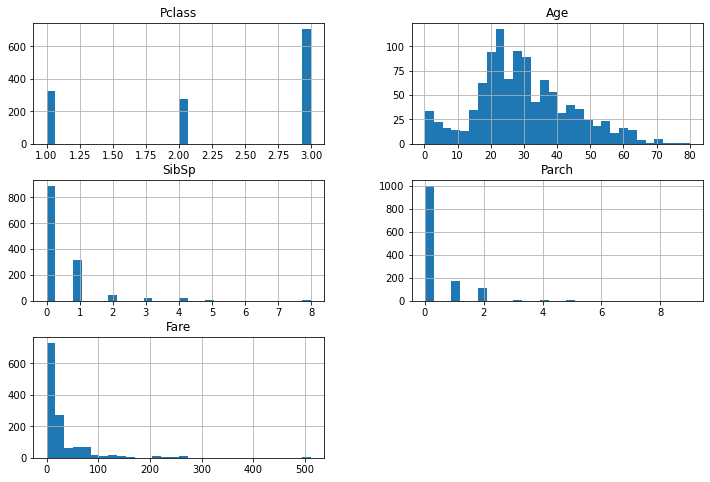

In [12]:
df.hist(bins=30, figsize=(12,8))
plt.show()

The above histograms show that Sibsp, Parch and Fare are right skewed. Many Fare values are 0, which should not be the case, considering them as invalid or NULL data. 

In [13]:
#Replace 0 values in Fare with NaN
df.loc[df['Fare']==0, 'Fare'] = np.NAN

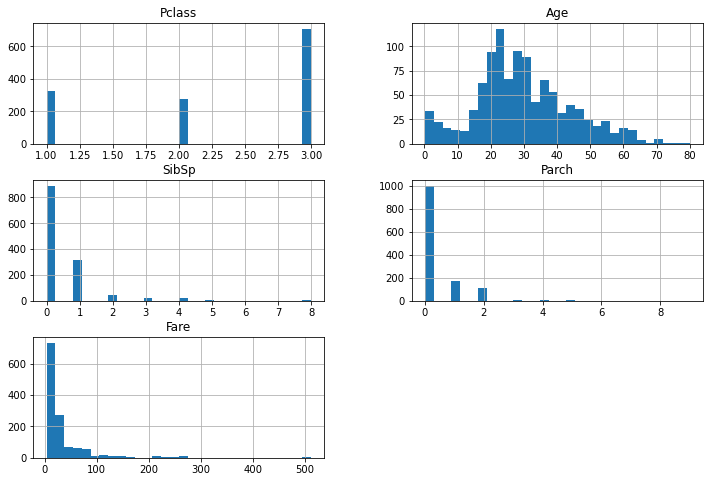

In [14]:
df.hist(bins=30, figsize=(12,8))
plt.show()

## Create Derived Features

In [15]:
#Create lastname feature from name
df['Lastname'] = df.Name.str.split(', ').str[0]
df['Lastname'].value_counts()

Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
             ..
Milling       1
Maisner       1
Goncalves     1
Campbell      1
Saether       1
Name: Lastname, Length: 875, dtype: int64

In [16]:
#Create title feature from name
df['Title'] = df.Name.str.split(', ').str[1]
df['Title'] = df.Title.str.split('. ').str[0]
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
th            1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

In [17]:
#There are some titles which are the same, so we can join them together. There are few titles which are occuring once or twice,
# so combining these titles under other

#Analyze the title "Mr" age
df[df.Title == "Mr"].Age.describe()

count    581.000000
mean      32.252151
std       12.422089
min       11.000000
25%       23.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [18]:
#Analyze the title "Master" age
df[df.Title == "Master"].Age.describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

It is observed that the title Mr has min value as 11, and title Master has max value as 14. So combining both the titles, and 
putting people under 18 as Master and people above 18 as Mr. Similarly, we perform this on Miss and Mrs

In [19]:
#Convert all Miss and equivalent title (for young, underage and unmarried) to Mrs; convert back Mrs with age<18 to Miss
females = ['Miss', 'Ms', 'Mme', 'Mlle', 'Mrs']
df.loc[df.Title.isin(females), 'Title'] = 'Mrs'

males = ['Mr', 'Master']
df.loc[df.Title.isin(males), 'Title'] = 'Mr'

#Change titles for underage females and males to Miss and Master respectively
df.loc[((df['Age']<18) & (df['Title'] == 'Mrs')), 'Title'] = 'Miss'
df.loc[((df['Age']<18) & (df['Title'] == 'Mr')), 'Title'] = 'Master'

df.loc[((~df.Title.isin(females)) & (~df.Title.isin(males))), 'Title'] = 'Others'

df['Title'].value_counts()

Mr        736
Mrs       390
Master     82
Miss       72
Others     29
Name: Title, dtype: int64


### Create Price feature

Price = Fare divided by number of Passengers on the same ticket

In [20]:
#Analyze Fare by ticket number, assuming fare is total ticket price and not price per person

# Split Ticket by series and number
df['Ticket_SL'] = [i[0] if len(i) > 1 else 0 for i in df.Ticket.str.split()]
df['Ticket_No'] = [i[-1] for i in df.Ticket.str.split()]

# Check if Fare min and Fare max of the same ticket number are the same
df_fare = df[~df.Fare.isna()]
multi_tickets = df_fare.groupby(df_fare.Ticket_No[df_fare.Ticket_No.duplicated()])
(multi_tickets.Fare.min() != multi_tickets.Fare.max()).sum()

1

There is only one ticket that corresponds to min and max fare being not same for the same ticket number. We will ignore this as a mistake

In [21]:
# Create a column with the passengers number by ticket 
ticket_dict = df.groupby('Ticket_No').Lastname.count().to_dict()

# print(ticket_dict)

df['Psgr_ticket'] = df.Ticket_No.map(ticket_dict)

# Create Price column
df['Price'] = (df.Fare / df.Psgr_ticket).round()

df['Psgr_ticket'].value_counts()

1     705
2     268
3     147
4      68
5      35
7      35
6      24
8      16
11     11
Name: Psgr_ticket, dtype: int64

### Create Deck feature

In [22]:
# Extract Deck letter from Cabin column
df['Deck'] = df.Cabin.str[0]

# Check how many missing values we have at this step
df.Deck.isna().sum()

1014

In [23]:
# Deck distribution by Pclass
df.groupby('Pclass').Deck.value_counts()

Pclass  Deck
1       C       94
        B       65
        D       40
        E       34
        A       22
        T        1
2       F       13
        D        6
        E        4
3       F        8
        G        5
        E        3
Name: Deck, dtype: int64

In [24]:
# Deck missing values by Pclass
df.loc[df.Deck.isna(), 'Pclass'].value_counts()

3    693
2    254
1     67
Name: Pclass, dtype: int64

On the 1st step we will impute the Deck letter based on Ticket_No, if the same Ticket_No has already an available value for Deck in other rows

On the 2nd step we will impute based on Lastname using the same method as in the first step, but to be sure that the passengers are not from different families with the same Lastname we will use some filters in the process.

On the 3rd step we will impute based on Pclass, as every Pclass was on separate Deck with some intersections between (some googling confirms that class-deck distribution corresponds to our Deck distribution by Pclass analysis). To improve the accuracy we will check also the mean Price for each Pclass-Deck group to determine the Deck.

In [25]:
# Function for imputing Deck
def impute_deck_by(feature):
    for pclass in range(1, 4):
        # Create a mapping dictionary
        map_dic = (df[~df.Deck.isna() 
                      & (df.Pclass == pclass)]
                       .groupby(feature)
                       .Deck.unique()
                       .apply(list).to_dict())
        # Keep just the keys with a single deck to avoid 
        # the same key on different decks
        map_dic = {i:j[0] for i, j in map_dic.items() 
                   if len(j) == 1}
        
        # Imputing Deck from map_dic
        df.loc[df.Deck.isna() & (df.Pclass == pclass), 
               'Deck'] = df[feature].map(map_dic)

    # Check how many missing values we have at this step
    print(df.Deck.isna().sum())

In [26]:
impute_deck_by('Ticket_No')

997


In [27]:
impute_deck_by('Lastname')

989


We have recovered 25 values, not much, but they correspond to reality, the rest we will impute later based on Pclass and Price as mentioned earlier.

## Analyze and Impute derived fields
### Analyze and impute missing prices

We impute prices first as there are less missing values in Price than in Deck and we use them both for imputation

In [28]:
# Analyze Price by Deck and Pclass
df.groupby(['Pclass', 'Deck']).Price.describe()

count       mean        std   min    25%   50%   75%    max
Pclass Deck                                                             
1      A      21.0  32.857143   7.066015  26.0  28.00  30.0  36.0   50.0
       B      65.0  43.030769  25.892789   5.0  29.00  37.0  46.0  128.0
       C     105.0  35.809524   9.686524  25.0  28.00  34.0  42.0   68.0
       D      42.0  31.904762   9.714986  20.0  26.00  27.5  38.0   67.0
       E      35.0  26.342857   5.058149   9.0  26.50  27.0  28.0   38.0
       T       1.0  36.000000        NaN  36.0  36.00  36.0  36.0   36.0
2      D       6.0  13.666667   0.816497  13.0  13.00  13.5  14.0   15.0
       E       6.0   9.500000   3.619392   5.0   6.25  11.0  12.0   13.0
       F      16.0  10.937500   1.691892   9.0  10.00  10.0  13.0   13.0
3      E       3.0   6.666667   1.154701   6.0   6.00   6.0   7.0    8.0
       F      11.0   7.545455   0.522233   7.0   7.00   8.0   8.0    8.0
       G       5.0   5.600000   0.547723   5.0   5.00   6.0   6.0    6.0

Very large standard deviation of Pclass 1, deck B, and this needs to be analysed

In [29]:
#Cabin T has only single value, so will merge this with Cabin A (2nd lowest value)
df.loc[df.Deck == 'T', 'Deck'] = 'A'

In [30]:
# Outlier treatment of Deck B
# Check the cheapest prices for Deck B
df[df.Deck == 'B'].sort_values('Price').head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_SL,Ticket_No,Psgr_ticket,Price,Deck
872,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,Carlsson,Mr,0,695,1,5.0,B
690,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0,B20,S,Dick,Mr,0,17474,3,19.0,B
781,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0,B20,S,Dick,Miss,0,17474,3,19.0,B
1199,1,"Hays, Mr. Charles Melville",male,55.0,1,1,12749,93.5,B69,S,Hays,Mr,0,12749,4,23.0,B
1281,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,Payne,Mr,0,12749,4,23.0,B


In [31]:
# Maybe Mr Carlsson paid just 5 pounds for that 1st class ticket, 
# but this value is an outlier that we will replace with the next min
df.loc[(df.Ticket_No == '695'), 'Price'] = 19

In [32]:
# Check the most expensive prices for Deck B
df[df.Deck == 'B'].sort_values('Price', ascending=False).head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_SL,Ticket_No,Psgr_ticket,Price,Deck
1234,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mrs,PC,17755,4,128.0,B
258,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Ward,Mrs,PC,17755,4,128.0,B
737,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Lesurer,Mr,PC,17755,4,128.0,B
679,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mr,PC,17755,4,128.0,B
118,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mr,PC,17558,3,83.0,B
1075,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1,1,PC 17558,247.5208,B58 B60,C,Douglas,Mrs,PC,17558,3,83.0,B
299,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mrs,PC,17558,3,83.0,B
730,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,Allen,Mrs,0,24160,4,53.0,B
1215,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S,Kreuchen,Mrs,0,24160,4,53.0,B
779,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,Robert,Mrs,0,24160,4,53.0,B


In [33]:
# Two most expensive tickets are outliers,
# we will cap them at the next overall highest Price 
df.loc[(df.Ticket_No == '17755'), 'Price'] = 53
df.loc[(df.Ticket_No == '17558'), 'Price'] = 53

In [34]:
# To fix the NULL values of price; Create a data frame of mean prices by Pclass and Deck 
class_deck_price = pd.DataFrame(df.groupby(['Pclass', 'Deck'])
                                .Price.mean().round(2)).reset_index()

# Impute missing prices 
# Where Deck is missing we will use the mean price by Pclass only
for index, row in df.loc[df.Price.isna(), 
                         ['Pclass', 'Deck']].iterrows():
    if not pd.isna(row.Deck):
        new_price = class_deck_price.loc[
            ((class_deck_price.Pclass == row.Pclass) 
            & (class_deck_price.Deck == row.Deck)), 'Price'].mean()
    else:
        new_price = class_deck_price[
            class_deck_price.Pclass == row.Pclass].Price.mean()

    df.loc[[index], 'Price'] = new_price

### Analyze and impute missing deck values

In [35]:
# Create dictionaries with approximate price ranges by deck 
# concluded from previous analysis
first_cl = {'A': [25, 30],
            'B': [35, 70],
            'C': [30, 35],
            'D': [19, 25],
            'E': [9, 19]}

second_cl = {'D': [13, 17],
             'E': [5, 9],
             'F': [9, 13]}

third_cl = {'E': [8, 9],
            'F': [9, 21],
            'G': [0, 8]}

# Create a dictionary pairing Pclass and respective price dictionary
class_dict = {1: first_cl,
              2: second_cl,
              3: third_cl}

# Impute missing Deck values 
for index, row in df.loc[df.Deck.isna(), ['Pclass', 'Price']].iterrows():
    for c, d in class_dict.items():
        if row.Pclass == c:
            for i, j in d.items():
                if max(j) > row.Price >= min(j):
                    df.loc[[index], 'Deck'] = i

# Encode Deck with it's deck level number counting from the bottom
deck_level = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}

df.Deck = df.Deck.replace(deck_level)

### Create 'Escape_density' feature

Crowded decks could lead to jams and chaos when everybody wanted to go to the upper deck as the lifeboats were there. This feature will show through which amount of people each deck passenger needed to pass to arrive on top. Basically for each deck we will have a number of people equal to the sum of its own value and all the decks that are upper from it.

In [36]:
# Analyse how many people were on each deck.
# Many values were imputed with approximation,but at least we'll have an approximate crowd mass each passenger has to pass going up
deck_people = df.Deck.value_counts().sort_index().to_dict()
deck_people

{1: 283, 2: 202, 3: 408, 4: 176, 5: 116, 6: 76, 7: 48}

In [37]:
# Create an escape density dictionary from which we will impute data to our new feature
escape_density = {}
for i in range(1, 8):
    escape_density[i] = sum(deck_people.values())
    del deck_people[i]
    
escape_density

{1: 1309, 2: 1026, 3: 824, 4: 416, 5: 240, 6: 124, 7: 48}

In [38]:
# Create Escape_density column
df['Escape_density'] = df.Deck.replace(escape_density)

### Create Family_size feature

It will represent how big the family was

In [39]:
# We add together the person and his SibSp and Parch
df['Family_size'] = 1 + df.SibSp + df.Parch

### Create Family_survivors

This feature can't be used for modeling as it will provide target leakage, but by analysing it later we can separate families that could have higher surviving chance

In [40]:
# Create full data frame for analysis
X = df[:X_max_idx]
test_df = df[X_max_idx:].copy()
train_df = pd.concat([X, y], axis=1).copy()

# Check for families that has survivors and create a dictionary with mean value of their family survivability
family_survivors = train_df[['Lastname', 'Survived']].groupby('Lastname').mean().round(2).reset_index()
family_survivors_dict = dict(zip(family_survivors.Lastname, family_survivors.Survived))

# Reduce the dictionary to the list of families that are both in train and test data
common_survivors = {}
for lastname, survived in family_survivors_dict.items():
    if lastname in list(test_df['Lastname'].unique()):
        common_survivors[lastname] = survived

# Create Family_survivors feature
test_df['family_survivors'] = test_df.Lastname.map(common_survivors)
train_df['family_survivors'] = train_df.Lastname.map(common_survivors)

# For the families that are not present in both train and test we will impute the overall mean value
test_df.family_survivors = test_df.family_survivors.fillna(test_df.family_survivors.mean())
train_df.family_survivors = train_df.family_survivors.fillna(train_df.family_survivors.mean())

# Separate back features and target
y = train_df.Survived

df = train_df.drop('Survived', axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

## Clean Data

In [41]:
# Change Pclass dtype to category as it's a classification feature
df.Pclass = df.Pclass.astype('category')

In [42]:
# Drop further unused columns
col_drop = ['Name', 'Ticket', 'Fare', 'Cabin', 'Lastname','Ticket_No',  
            'Ticket_SL', 'Psgr_ticket']
df = df.drop(col_drop, axis=1)

## Impute Categorical features

In [43]:
# List of categorical columns
categ_cols = list(df.select_dtypes(['object', 'category']).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

df_cat = cat_imputer.fit_transform(df[categ_cols])
df_cat = pd.DataFrame(df_cat, columns=df[categ_cols].columns)


In [44]:
df_cat

,Pclass,Sex,Embarked,Title
0,3,male,S,Mr
1,1,female,C,Mrs
2,3,female,S,Mrs
3,1,female,S,Mrs
4,3,male,S,Mr
...,...,...,...,...
1304,3,male,S,Mr
1305,1,female,C,Others
1306,3,male,S,Mr
1307,3,male,S,Mr


## Encode categorical features

In [45]:
# Encode categoricals with One Hot Encoding
ohe = OneHotEncoder(sparse=False)

df_cat = pd.DataFrame(ohe.fit_transform(df_cat),
                  columns=ohe.get_feature_names_out())

In [46]:
df_cat

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1305,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1306,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1307,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Impute numericals

In [47]:
# List of numerical columns
num_cols = [col for col in df.columns 
            if df[col].dtype in ['int64', 'float64']]

# Impute numericals
it_imp = IterativeImputer()

df_num = pd.DataFrame(it_imp.fit_transform(df[num_cols]),
                      columns=df[num_cols].columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df_num], axis=1)

In [48]:
df_num

,Age,SibSp,Parch,Price,Deck,Escape_density,Family_size,family_survivors
0,22.000000,1.0,0.0,7.0,1.0,1309.0,2.0,0.421647
1,38.000000,1.0,0.0,36.0,5.0,240.0,2.0,1.000000
2,26.000000,0.0,0.0,8.0,3.0,824.0,1.0,0.421647
3,35.000000,1.0,0.0,27.0,5.0,240.0,2.0,0.421647
4,35.000000,0.0,0.0,8.0,3.0,824.0,1.0,0.421647
...,...,...,...,...,...,...,...,...
1304,28.902015,0.0,0.0,8.0,3.0,824.0,1.0,0.487234
1305,39.000000,0.0,0.0,36.0,5.0,240.0,1.0,0.487234
1306,38.500000,0.0,0.0,7.0,1.0,1309.0,1.0,0.487234
1307,28.902015,0.0,0.0,8.0,3.0,824.0,1.0,0.487234


## Feature Engineering

In [49]:
# Create a full data frame for analysis
X = df[:X_max_idx]
train_df = pd.concat([X, y], axis=1)

In [50]:
# Function for kde plotting
def survive_chance_by(feature, xticks=None, xlim=None):
    survived = train_df[train_df.Survived == 1]
    not_survived = train_df[train_df.Survived == 0]

    plt.figure(figsize=(10, 5))

    survived[feature].plot(kind='kde', label='survived')
    not_survived[feature].plot(kind='kde', label='not_survived')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

## Create bins for categorical variables
### Create Age_Group feature

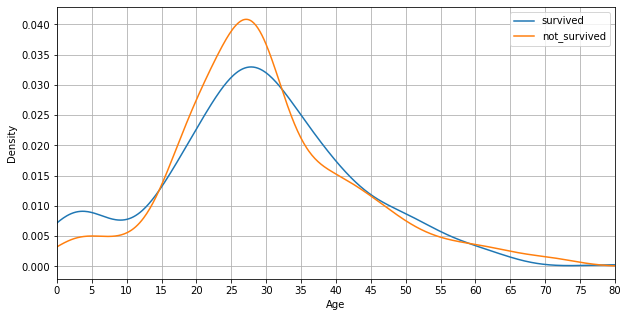

In [51]:
# Survivers by Age
survive_chance_by('Age', np.arange(0, 81, 5), (0, 80))

By curves intersection points we can separate 4 age groups:

1. 0-15 years old have higher survivability chance
2. 15-32 years old low chance
3. 32-44 years old better chance
4. For the rest the chances are almost equal

In [52]:
df['Age_group'] = pd.cut(x=df.Age, bins=[0, 15, 32, 44, df.Age.max()],
                         labels=['Child', 'Young', 'Adult', 'Old'])

### Create Family_group feature

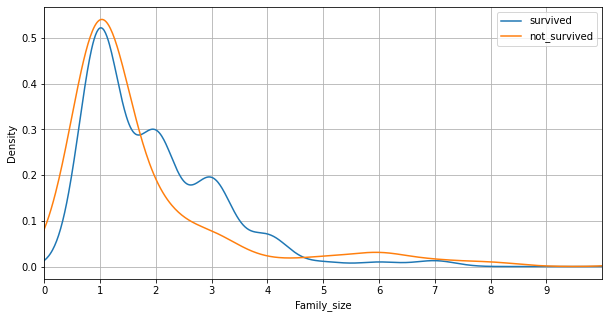

In [53]:
# Survivers by Family_size
survive_chance_by('Family_size', np.arange(0, 10, 1), (0, 10))

Here we can separate 3 groups:

1. Single persons had lower chance to survive
2. 2-4 members families had higher chances, as they had some priority to safeboats with female and/or 1-2 children with them
3. 5 and more members families had almost equal chances

In [54]:
# Create Family_group feature
df['Family_group'] = pd.cut(x=df.Family_size, 
                            bins=[0, 1, 4, df.Family_size.max()],
                            labels=['Single', 'Medium', 'Large'])

### Create Lucky_family feature

To create this feature we analyse earlier created Family_survivers that used by itself would overfit the model

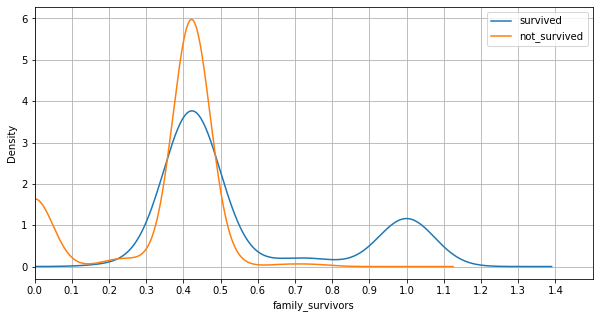

In [55]:
# Survivers by Family_survivors
survive_chance_by('family_survivors', np.arange(0, 1.5, 0.1), (0, 1.5))

In [56]:
# Create Lucky_family feature
df['Lucky_family'] = pd.cut(x=df.family_survivors, 
                            bins=[0, 0.22, 0.35, 0.49, df.family_survivors.max()],
                            labels=['Low', 'Medium', 'Very_low', 'High'])

In [57]:
# Encode categoricals
df = pd.get_dummies(df)

## Standardization

In [58]:
# Apply np.log to normalize the skewed right Price
df.Price = df.Price.apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [59]:
# Drop features not used for modeling
cols_to_drop = ['family_survivors', 'SibSp', 'Parch', 'Family_size']
df = df.drop(cols_to_drop, axis=1)

In [60]:
# Split train and test data

X = df[:X_max_idx]
test_df = df[X_max_idx:]

## Processed data correlation

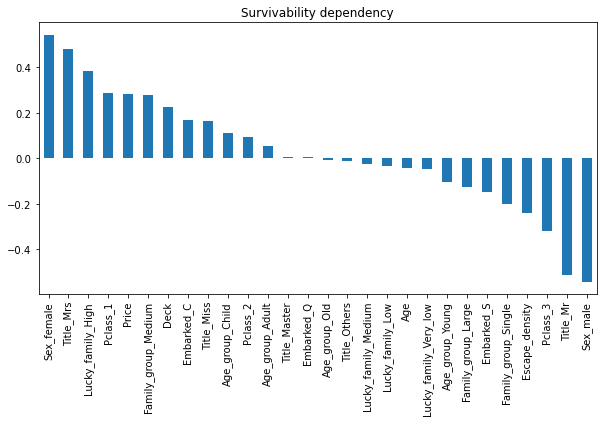

In [61]:
# Concatenate into a full dataset
train_df = pd.concat([X, y], axis=1)

correlation = train_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

## Conclusion on Data Analysis:

On the Titanic is better to not be an usual single adult male on a lower deck and embarked from Southampton with a cheap ticket in the pocket 

In [62]:
score_list = []
score_name = []

## ML Model Building

### 1. CatBoost grid search parameter tuning

In [63]:
# Define model
cat_model = CatBoostClassifier()

# Define parameters' grid
grid = {'verbose': [False],
        'thread_count': [-1],
        'depth': [4, 5],
        'iterations': [2000, 3000],
        'learning_rate': [0.0001, 0.0003]}

# Define GridSearchCV
grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
grid_cat.fit(X, y)

print('Results from Grid Search')
print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best parameters:\n', grid_cat.best_params_)

Results from Grid Search

 Best Score:
 0.8395061728395062

 Best parameters:
 {'depth': 5, 'iterations': 3000, 'learning_rate': 0.0003, 'thread_count': -1, 'verbose': False}


In [64]:
score_name.append("CatBoost")
score = round(np.mean(grid_cat.best_score_)*100, 2)
score_list.append(score)
score

83.95

### CatBoost model test

In [65]:
# Define parameters
# They were manualy adjusted after grid search as gave a better leaderboard score
params = {'depth': 5, 
          'iterations': 3000, 
          'learning_rate': 0.0003, 
          'thread_count': -1, 
          'verbose': False}

# Define and fit the model
cat_model = CatBoostClassifier(**params)
cat_model.fit(X, y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X, y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

count    5.000000
mean     0.837223
std      0.028027
min      0.803371
25%      0.820225
50%      0.831461
75%      0.859551
max      0.871508
dtype: float64

                Feature Id  Importances
0       Lucky_family_High    20.465878
1                Sex_male    16.496883
2              Sex_female    16.124939
3                Title_Mr     9.020677
4                Pclass_3     6.296449
5   Lucky_family_Very_low     6.245410
6                   Price     4.347093
7      Family_group_Large     3.504851
8          Escape_density     2.486686
9                     Age     2.470038
10                   Deck     2.407854
11        Age_group_Child     1.996548
12               Pclass_1     1.989909
13              Title_Mrs     1.318894
14    Family_group_Medium     1.142268
15               Pclass_2     0.951267
16        Age_group_Young     0.481374
17    Family_group_Single     0.468946
18           Title_Master     0.402175
19        Age_group_Adult     0.331592
20           Title_O

### 2.Random Forest parameter tuning

In [66]:
# Define model
RF_model = RandomForestClassifier()

# Define parameters' grid
grid = {'verbose': [False],
        'max_depth': [4, 5, 6],
        'n_estimators': [1000, 2000, 3000]
        }

# Define GridSearchCV
grid_RF = GridSearchCV(RF_model, param_grid=grid, cv=3, n_jobs=-1)
grid_RF.fit(X, y)

print('Results from Grid Search')
print('\n Best Score:\n', grid_RF.best_score_)
print('\n Best parameters:\n', grid_RF.best_params_)

Results from Grid Search

 Best Score:
 0.8338945005611672

 Best parameters:
 {'max_depth': 4, 'n_estimators': 3000, 'verbose': False}


In [67]:
score_name.append("RandomForest")
score = round(np.mean(grid_RF.best_score_)*100, 2)
score_list.append(score)
score

83.39

### Random Forest Model test

In [68]:
# Define parameters
# They were manualy adjusted after grid search as gave a better leaderboard score
params = {'max_depth': 6, 
          'n_estimators': 3000, 
          'verbose': False}

# Define and fit the model
RF_model = RandomForestClassifier(**params)
RF_model.fit(X, y)

# Check accuracy and features importance
RF_rmses = cross_val_score(RF_model, X, y, cv=5)

print(pd.Series(RF_rmses).describe())
print('\n', RF_model.feature_importances_)

count    5.000000
mean     0.828278
std      0.019344
min      0.808989
25%      0.808989
50%      0.832402
75%      0.837079
max      0.853933
dtype: float64

 [0.02977769 0.01398874 0.05497508 0.14099726 0.14967191 0.00826128
 0.00393107 0.00952574 0.00745042 0.00650688 0.10094678 0.07859006
 0.00446833 0.06088598 0.06417661 0.03245766 0.03031924 0.01437351
 0.00744024 0.00567238 0.00496993 0.01088423 0.02474092 0.02611519
 0.0027436  0.00535903 0.01818548 0.08258477]


### 3.Support Vector Machine paramter tuning

In [69]:
# Define model
SV_model = SVC()

# Define parameters' grid

grid = { 
    # Regularization parameter.
    "C": np.logspace(-1, 1, 3),
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": np.logspace(-1, 1, 3).tolist()+['scale', 'auto']
    }

# Define GridSearchCV
grid_SV = GridSearchCV(SV_model, param_grid=grid, cv=3, n_jobs=-1)
grid_SV.fit(X, y)

print('Results from Grid Search')
print('\n Best Score:\n', grid_SV.best_score_)
print('\n Best parameters:\n', grid_SV.best_params_)


Results from Grid Search

 Best Score:
 0.8383838383838383

 Best parameters:
 {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [70]:
score_name.append("SVM")
score = round(np.mean(grid_SV.best_score_)*100, 2)
score_list.append(score)
score

83.84

### Support Vector model test

In [71]:
# Define parameters
# They were manualy adjusted after grid search as gave a better leaderboard score
params = {'C': 1.0, 
          'gamma': 'scale', 
          'kernel': 'rbf'}

# Define and fit the model
SV_model = SVC(**params)
SV_model.fit(X, y)

# Check accuracy and features importance
SV_rmses = cross_val_score(SV_model, X, y, cv=5)

print(pd.Series(SV_rmses).describe())

count    5.000000
mean     0.827186
std      0.025620
min      0.803371
25%      0.804469
50%      0.825843
75%      0.837079
max      0.865169
dtype: float64


## Comparing ML scores of different ML models

<BarContainer object of 3 artists>

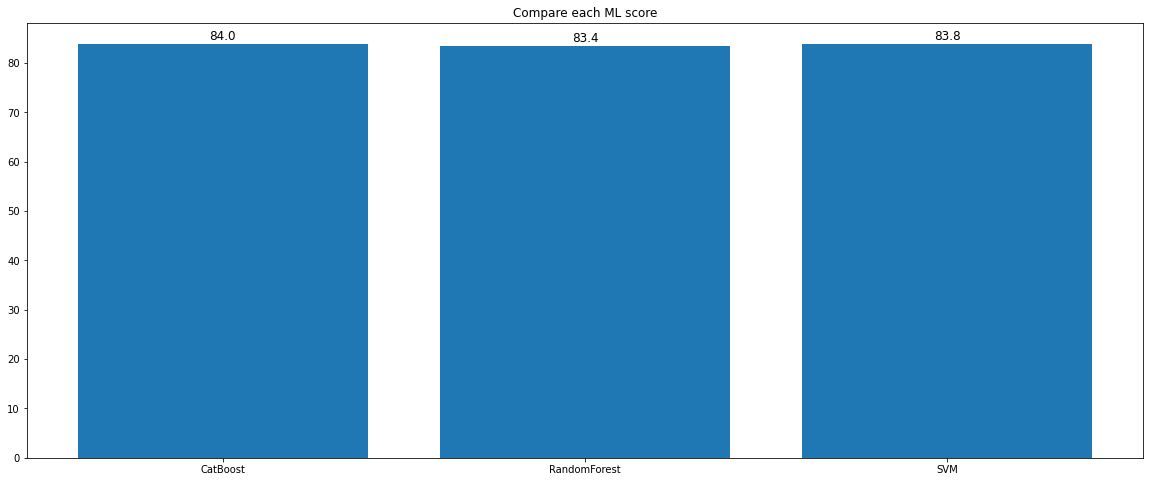

In [72]:
a = score_name
b = score_list
plt.figure(figsize=(20,8))
for i in range(len(a)):
    height = b[i]
    plt.text(a[i], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)
    
plt.title("Compare each ML score")
plt.bar(a,b)

## Use Deep Learning Predict Result

In [73]:
import tensorflow as tf

In [74]:
X #Train data

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,...,Age_group_Young,Age_group_Adult,Age_group_Old,Family_group_Single,Family_group_Medium,Family_group_Large,Lucky_family_Low,Lucky_family_Medium,Lucky_family_Very_low,Lucky_family_High
0,-0.572351,-0.518084,0.919925,-0.743497,0.743497,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,-1.233758,1.412595,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
1,1.747178,-0.518084,-1.087045,1.344995,-1.344995,1.96167,-0.322040,-1.526692,-0.258514,-0.241258,...,-1.165572,2.043016,-0.398004,-1.233758,1.412595,-0.258514,-0.092057,-0.130744,-1.412595,2.281182
2,-0.572351,-0.518084,0.919925,1.344995,-1.344995,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,0.810532,-0.707917,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
3,1.747178,-0.518084,-1.087045,1.344995,-1.344995,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,-1.165572,2.043016,-0.398004,-1.233758,1.412595,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
4,-0.572351,-0.518084,0.919925,-0.743497,0.743497,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,-1.165572,2.043016,-0.398004,0.810532,-0.707917,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.572351,1.930190,-1.087045,-0.743497,0.743497,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,0.810532,-0.707917,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
887,1.747178,-0.518084,-1.087045,1.344995,-1.344995,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,0.810532,-0.707917,-0.258514,-0.092057,-0.130744,0.707917,-0.438369
888,-0.572351,-0.518084,0.919925,1.344995,-1.344995,-0.50977,-0.322040,0.655011,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,-1.233758,1.412595,-0.258514,-0.092057,-0.130744,-1.412595,-0.438369
889,1.747178,-0.518084,-1.087045,-0.743497,0.743497,1.96167,-0.322040,-1.526692,-0.258514,-0.241258,...,0.857948,-0.489473,-0.398004,0.810532,-0.707917,-0.258514,-0.092057,-0.130744,0.707917,-0.438369


In [75]:
y #Target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [76]:
model = tf.keras.models.Sequential(
[
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(np.array(X), np.array(y), epochs=50)

2023-02-13 03:52:29.345045: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-13 03:52:29.455958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
28/28 [==============================] - 1s 6ms/step - loss: 0.6690 - accuracy: 0.5982
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.5965 - accuracy: 0.6700
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4908 - accuracy: 0.8047
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4362 - accuracy: 0.8294
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4431 - accuracy: 0.8384
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.3931 - accuracy: 0.8485
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4041 - accuracy: 0.8440
Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4047 - accuracy: 0.8406
Epoch 9/50
28/28 [==============================] - 0s 4ms/step - loss: 0.3837 - accuracy: 0.8440
Epoch 10/50
28/28 [==============================] - 0s 4ms/step - loss: 0.3895 - accuracy: 0.8384
Epoch 11/50
28/28 [

In [77]:
submission_dl = []

In [78]:
for i in range(len(model.predict(test_df))):
    if model.predict(test_df)[i][0] > 0.5:
        submission_dl.append(1)
    else:
        submission_dl.append(0)

In [79]:
prediction_dl = np.array(submission_dl)

In [80]:
#Attempted deep learning. Please suggest improvements

## Final submission using best ML Result

In [81]:
# Make predictions which we will submit.
test_preds = cat_model.predict(test_df)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_id,
                       'Survived': test_preds})
output.to_csv('submission.csv', index=False)